# Basic Model Training with TensorFlow 2.0

## Objectives

* Set-up Notebook on AI Platform with TensorFlow 2.0 image
* Enable APIs for Compute Engine, BigQuery, and Cloud ML Engine
* Stage preprocessed data using BigQuery
* Prepare data for model input
* Defined a logistic regression model
* Train it on approximately 2M rows using tf.keras
* Call predictions from the trained model 
* Evaluate model to SavedModel files
* Deploy model versions to AI Platform

## Project Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

tf.__version__

'2.2.0-dlenv'

## Staging Data

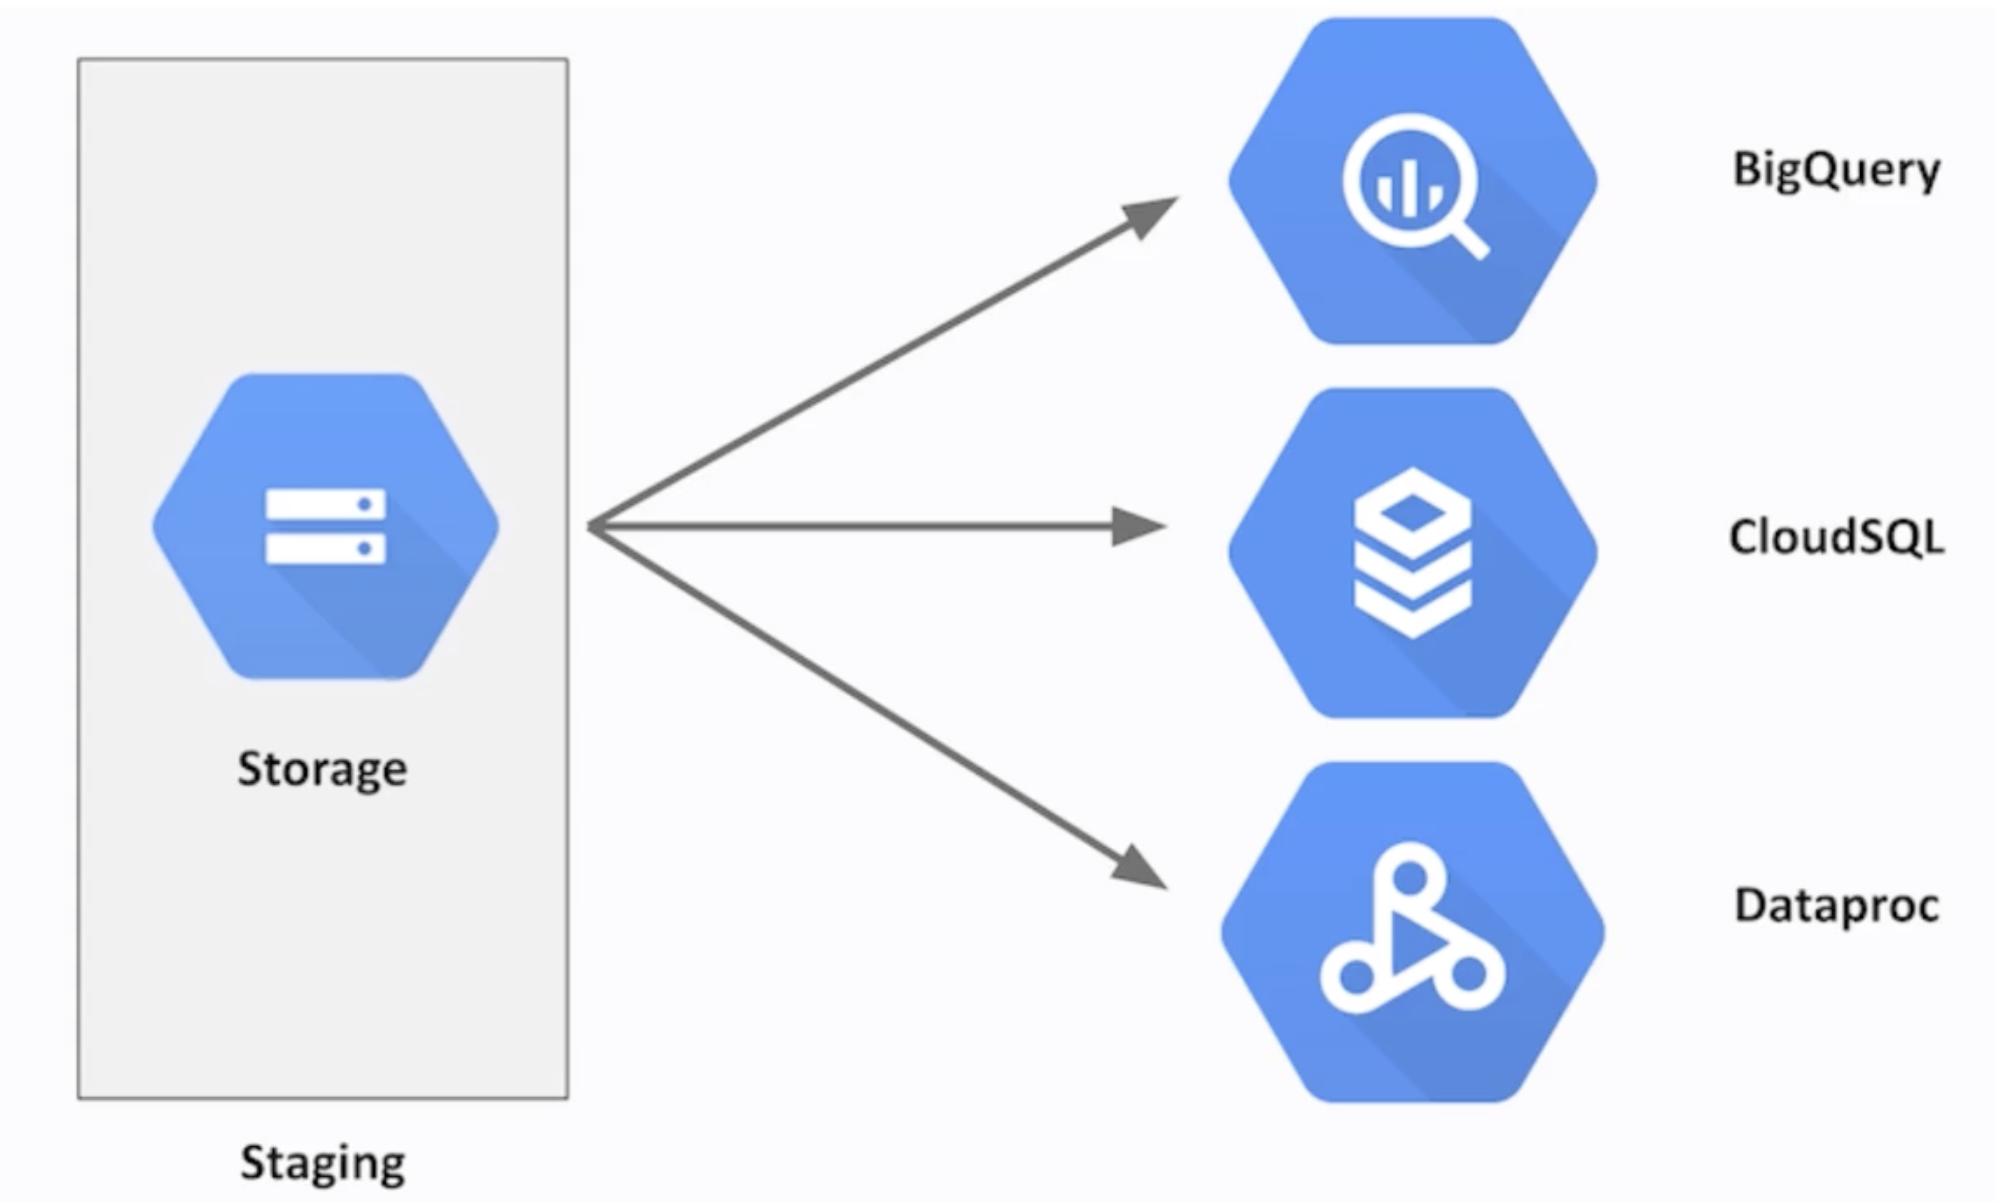

In [2]:
from IPython.display import Image
Image("images/staging.png", width=500, height=300) 

##### Pros and Cons of Preprocessing Data in BigQuery

* (+) Efficient transformations
* (+) Easy to apply to new data within schema
* (+) Scalability
* (-) Limited Features
* (-) Transfer over Network


We are using the **Airline on time data set** from BQ samples datasets, and our goal is to predict whether a flight will be delayed on arrival. 

Firs let's briefly discuss some key points regarding data pre-processing.

There are many ways where your data can be stored and how you can access it. When you are dealing with flat files it might be that they are stored in a blob storage somewhere such as **Cloud Storage**, so that you need to copy them over the network onto your working machine in order to work with them. 

Another scenario your data might reside in a data warehouse, or a database such as **BigQuery** or **CloudSQL** where you can access it, and that is quite often the case because normally you won't analyze some data that is lying around somewhere, but instead data that is the result of some business process stored in the database. 

When we use this kind of business data and prepared for machine learning tasks, we will always need to do some pre-processing, be it transformations, calculations or whatever. Now the question is where do we do those tasks. 

When you are working with data in databases, one concept is to **shift** as much transformation and pre-processing workload away from your client VM back to the database. This basically happens for two reasons. First, the database typically handles these processing tasks much more efficiently than your local machine, and second once you define the transformation in SQL, you can easily access them by creating views in your database. When you use a serverless data warehouse such as **BigQuery**, these advantages are supported by the fact that you are not limited by any server capacity. On the downside of course, you are limited in terms of processing functionality, and also the more new columns you generate the more traffic needs to be sent over the network, which can reach a bottleneck pretty quickly. 

In this case, let's use **BigQuery** to do some of pre-processing. 

In [3]:
%%bigquery flights_df --verbose

SELECT 

    -- We are binning the departure delay to capture the data better 0, 2, 3, 6, 9, 13, 28, 44, 76, 120
    CASE WHEN (departure_delay < 2) THEN 1 ELSE 0 END AS departure_delay_bin_0, 
    CASE WHEN (2 <= departure_delay AND departure_delay < 3) THEN 1 ELSE 0 END AS departure_delay_bin_1,
    CASE WHEN (3 <= departure_delay AND departure_delay < 6) THEN 1 ELSE 0 END AS departure_delay_bin_2,
    CASE WHEN (6 <= departure_delay AND departure_delay < 9) THEN 1 ELSE 0 END AS departure_delay_bin_3,
    CASE WHEN (9 <= departure_delay AND departure_delay < 13) THEN 1 ELSE 0 END AS departure_delay_bin_4,
    CASE WHEN (13 <= departure_delay AND departure_delay < 19) THEN 1 ELSE 0 END AS departure_delay_bin_5,
    CASE WHEN (19 <= departure_delay AND departure_delay < 28) THEN 1 ELSE 0 END AS departure_delay_bin_6,
    CASE WHEN (28 <= departure_delay AND departure_delay < 44) THEN 1 ELSE 0 END AS departure_delay_bin_7,
    CASE WHEN (44 <= departure_delay AND departure_delay < 76) THEN 1 ELSE 0 END AS departure_delay_bin_8,
    CASE WHEN (76 <= departure_delay) THEN 1 ELSE 0 END AS departure_delay_bin_9,
    
    departure_delay, -- just for demo purposes
    
    -- We are binning the distance to capture the data better 600, 1200 km
    CASE WHEN (distance < 600) THEN 1 ELSE 0 END AS distance_bin_0,
    CASE WHEN(600 <= distance AND distance < 1200) THEN 1 ELSE 0 END AS distance_bin_1,
    CASE WHEN(1200 <= distance) THEN 1 ELSE 0 END AS distance_bin_2, 
    
    -- Target column 
    CASE WHEN (arrival_delay >= 15) THEN 1 ELSE 0 END as delayed
    
FROM (
    -- Inner Query
    SELECT 
        ROUND(ST_DISTANCE(ST_GEOGPOINT(departure_lon, departure_lat), 
                          ST_GEOGPOINT(arrival_lon, arrival_lat))/1000
             ) as distance,
        departure_delay,
        arrival_delay
    FROM
        `bigquery-samples.airline_ontime_data.flights`
    WHERE date >= '2009-01-01'
    AND date <= '2009-12-31'
    AND departure_delay > 0
)

Executing query with job ID: f5f2b341-4294-46be-a8e5-0de9bcd76615
Query executing: 0.72s
Query complete after 1.03s



In this script we are calling a nested SQL statement. The inner statement will select some variables and we are calculating a distance column directly based on the latitude and longitude data. there's some more pre-processing in the outer query. 

Some other things that are happening here: 

1. We are binning the data 

2. We are limiting our training data to the first month of 2009

3. We are just creating departure delays greater than the 0. 

Note that we are selecting all airports now, which yields a much bigger data set of course. So if we look a bit further down at the result of the script, we can see that processing went pretty fast

In [4]:
flights_df.shape

(2302332, 15)

In [5]:
flights_df.sample(n = 10)

departure_delay_bin_0  departure_delay_bin_1  departure_delay_bin_2  \
1625705                      0                      0                      0   
786403                       0                      0                      0   
784642                       0                      0                      0   
58835                        0                      0                      0   
1263716                      0                      0                      0   
1884541                      0                      0                      0   
1973682                      0                      0                      0   
2014602                      0                      0                      0   
1350924                      0                      0                      0   
119941                       0                      0                      0   

         departure_delay_bin_3  departure_delay_bin_4  departure_delay_bin_5  \
1625705                      0                      0                      0   
786403                       0                      0                      0   
784642                       0                      0                      0   
58835                        0                      0                      0   
1263716                      1                      0                      0   
1884541                      0                      0                      0   
1973682                      0                      0                      0   
2014602                      0                      0                      0   
1350924                      0                      1                      0   
119941                       0                      0                      0   

         departure_delay_bin_6  departure_delay_bin_7  departure_delay_bin_8  \
1625705                      0                      0                      1   
786403                       0                      1                      0   
784642                       0                      1                      0   
58835                        0                      1                      0   
1263716                      0                      0                      0   
1884541                      0                      0                      0   
1973682                      0                      1                      0   
2014602                      1                      0                      0   
1350924                      0                      0                      0   
119941                       0                      1                      0   

         departure_delay_bin_9  departure_delay  distance_bin_0  \
1625705                      0             68.0               0   
786403                       0             35.0               0   
784642                       0             37.0               0   
58835                        0             39.0               1   
1263716                      0              6.0               0   
1884541                      1            103.0               0   
1973682                      0             31.0               1   
2014602                      0             27.0               0   
1350924                      0              9.0               0   
119941                       0             35.0               1   

         distance_bin_1  distance_bin_2  delayed  
1625705               0               1        1  
786403                0               1        0  
784642                1               0        1  
58835                 0               0        1  
1263716               0               1        0  
1884541               0               1        1  
1973682               0               0        1  
2014602               0               1        0  
1350924               0               1        0  
119941                0               0        1

In this case we are counting a total of two million rows over 15 columns, and sank to BigQuery it just takes seconds to query that data, transfer it over the network to my local machine, and make it accessible in memory for Pandas. So isn't that great that's a really handy tool. 

## Data Preprocessing


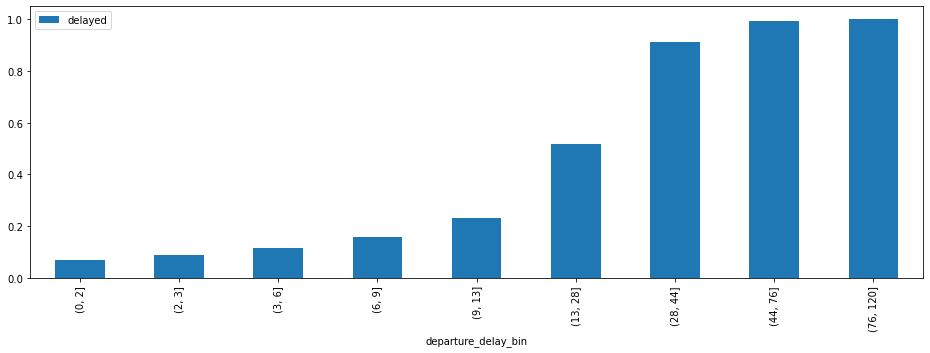

In [6]:
flights_df['departure_delay_bin'] = pd.cut(flights_df['departure_delay'], [0, 2, 3, 6, 9, 13, 28, 44, 76, 120])
(flights_df
     .filter(['departure_delay_bin', 'delayed'])
     .groupby('departure_delay_bin')
     .agg('mean')
     .plot.bar(figsize = (16, 5))
)

When we cut the data into percentiles then our distribution looks like this. You can see this interesting trend here. Actually the risk of delay is not growing linear of a higher departure delay. If we kept the departure delay as a numeric variable, it would be very hard for a logistic regression to capture this nonlinear trend, because it could assign only one weight, and this essentially behaves in a linear fashion. 

**Why are we bining?** 

The bins make it easier for the model to fit the data according to the distribution. To make it easier to control I'm hard-coding my own binning intervals here because on the distribution that I observe. 

Now let's drop the departure_delay numeric variable because we don't need it.

In [7]:
flights_df = flights_df.drop(columns = ['departure_delay_bin', 'departure_delay'])

In [8]:
flights_df.dtypes

departure_delay_bin_0    int64
departure_delay_bin_1    int64
departure_delay_bin_2    int64
departure_delay_bin_3    int64
departure_delay_bin_4    int64
departure_delay_bin_5    int64
departure_delay_bin_6    int64
departure_delay_bin_7    int64
departure_delay_bin_8    int64
departure_delay_bin_9    int64
distance_bin_0           int64
distance_bin_1           int64
distance_bin_2           int64
delayed                  int64
dtype: object

These are all thirteen columns which are one hot encoded, 
either for departure delay or for distance. 

In [9]:
%%bigquery count_flights_df --verbose

SELECT
  departure_delay,
  COUNT(1) AS num_flights,
  APPROX_QUANTILES(arrival_delay, 4) AS arrival_delay_quantiles
FROM
  `bigquery-samples.airline_ontime_data.flights`
GROUP BY
  departure_delay
HAVING
  num_flights > 100
ORDER BY
  departure_delay ASC

Executing query with job ID: 2b8680af-28df-4377-97f0-ad8fd67c33ba
Query executing: 0.76s
Query complete after 1.05s


In [10]:
count_flights_df.sample(n = 10)

departure_delay  num_flights              arrival_delay_quantiles
484            447.0          125  [392.0, 433.0, 443.0, 454.0, 546.0]
361            324.0          621  [263.0, 309.0, 319.0, 332.0, 475.0]
276            239.0         2196  [122.0, 227.0, 235.0, 246.0, 420.0]
139            102.0        27290     [35.0, 91.0, 99.0, 108.0, 376.0]
110             73.0        52837      [-4.0, 62.0, 69.0, 78.0, 368.0]
263            226.0         2704  [129.0, 214.0, 222.0, 234.0, 437.0]
71              34.0       163452     [-42.0, 23.0, 30.0, 38.0, 421.0]
130             93.0        33171      [16.0, 82.0, 89.0, 99.0, 395.0]
165            128.0        16230   [30.0, 117.0, 125.0, 135.0, 532.0]
106             69.0        56917     [-14.0, 58.0, 65.0, 75.0, 348.0]

**What is the median arrival delay for flights left 35 minutes early?** 

Ans: We see the typical flight that left 35 minutes early arrived 19 minutes early.

Let's write a query to find the airport pair (departure and arrival airport) that had the maximum number of flights between them

In [11]:
%%bigquery airport_pair_max_flights_df --verbose

SELECT
  departure_airport,
  arrival_airport,
  COUNT(1) AS num_flights
FROM
  `bigquery-samples.airline_ontime_data.flights`
GROUP BY
  departure_airport,
  arrival_airport
ORDER BY
  num_flights DESC
LIMIT
  10

Executing query with job ID: 5aa4bd2d-049a-4dc2-91cf-2a2cd7b1168b
Query executing: 0.35s
Query complete after 0.65s


In [12]:
airport_pair_max_flights_df.sample(n = 10)

departure_airport arrival_airport  num_flights
3               LAS             LAX       128546
0               LAX             SAN       133394
2               LAX             LAS       130381
5               LAX             SFO       121459
8               LGA             ORD       111314
9               ORD             LGA       110040
1               SAN             LAX       133068
4               SFO             LAX       123488
7               LGA             BOS       118745
6               BOS             LGA       119268

### Departure delay and arrival delay deciles

In [13]:
%%bigquery df --verbose

SELECT
  departure_delay,
  COUNT(1) AS num_flights,
  APPROX_QUANTILES(arrival_delay, 10) AS arrival_delay_deciles
FROM
  `bigquery-samples.airline_ontime_data.flights`
GROUP BY
  departure_delay
HAVING
  num_flights > 100
ORDER BY
  departure_delay ASC

Executing query with job ID: f217ac23-b181-4545-853d-ec3e3b121e51
Query executing: 0.38s
Query complete after 0.67s


In [14]:
df.head()

departure_delay  num_flights  \
0            -37.0          107   
1            -36.0          139   
2            -35.0          191   
3            -34.0          195   
4            -33.0          227   

                               arrival_delay_deciles  
0  [-66.0, -44.0, -41.0, -35.0, -30.0, -23.0, -17...  
1  [-74.0, -43.0, -39.0, -37.0, -32.0, -25.0, -18...  
2  [-68.0, -45.0, -40.0, -36.0, -28.0, -19.0, -14...  
3  [-58.0, -44.0, -40.0, -35.0, -30.0, -25.0, -19...  
4  [-59.0, -43.0, -39.0, -36.0, -32.0, -28.0, -20...

In [15]:
import pandas as pd

percentiles = df['arrival_delay_deciles'].apply(pd.Series)

percentiles = percentiles.rename(columns = lambda x : str(x*10) + "%")

df = pd.concat([df['departure_delay'], percentiles], axis=1)

df.head()

departure_delay    0%   10%   20%   30%   40%   50%   60%   70%  80%  90%  \
0            -37.0 -66.0 -44.0 -41.0 -35.0 -30.0 -23.0 -17.0 -12.0 -3.0  6.0   
1            -36.0 -74.0 -43.0 -39.0 -37.0 -32.0 -25.0 -18.0 -14.0 -7.0  2.0   
2            -35.0 -68.0 -45.0 -40.0 -36.0 -28.0 -19.0 -14.0  -8.0 -4.0  3.0   
3            -34.0 -58.0 -44.0 -40.0 -35.0 -30.0 -25.0 -19.0 -14.0 -8.0  2.0   
4            -33.0 -59.0 -43.0 -39.0 -36.0 -32.0 -28.0 -20.0 -14.0 -7.0  5.0   

   100%  
0  33.0  
1  49.0  
2  85.0  
3  39.0  
4  25.0

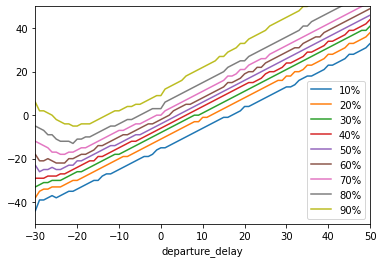

In [16]:
without_extremes = df.drop(['0%', '100%'], 1)
without_extremes.plot(x='departure_delay', xlim=(-30,50), ylim=(-50,50));

**To think**: Suppose we were creating a machine learning model to predict the arrival delay of a flight. Do you think departure delay is a good input feature? Is this true at all ranges of departure delays?

## Model Training using Keras API

### Training-Testing-Split

In [17]:
train_df = flights_df.sample(frac=0.85, random_state=123)
test_df = flights_df.drop(train_df.index)
print(train_df.delayed.mean())
print(test_df.delayed.mean())

train_labels = train_df.pop('delayed')
test_labels = test_df.pop('delayed')

0.45090501598890537
0.4509598957579267


In [18]:
# Initialize a Sequential model using TF.Keras API:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape = [len(train_df.keys())])
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


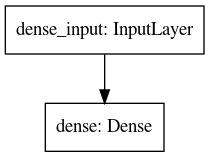

In [20]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

The model itself is still very simple (logistic regression). The complexity comes through feeature engineering and dummy variables. For the regression though this isn't a problem because many of the computations will be 0 because it is essentially a weighted sum.

In [21]:
%load_ext tensorboard

In [22]:
history = model.fit(
    train_df, # X_train 
    train_labels, # y_train
    epochs = 3,
    callbacks = [tf.keras.callbacks.TensorBoard("logs/logistic-regression")]
)

Epoch 1/3
61156/61156 [==============================] - 227s 4ms/step - loss: 0.3549 - accuracy: 0.8524
Epoch 2/3
61156/61156 [==============================] - 228s 4ms/step - loss: 0.3448 - accuracy: 0.8565
Epoch 3/3
61156/61156 [==============================] - 205s 3ms/step - loss: 0.3448 - accuracy: 0.8565


## Testing Model Predictions

### Performance evaluation of logistic regression on test data

In [24]:
test_predictions = model.predict(test_df).flatten()

test_predictions[:10]

array([0.35973632, 0.06794363, 0.90792173, 0.08688712, 1.        ,
       0.9120301 , 0.37136868, 0.37136868, 1.        , 1.        ],
      dtype=float32)

In [25]:
predicted_labels = (test_predictions > 0.5).astype(int)

predicted_labels[:10]

array([0, 0, 1, 0, 1, 1, 0, 0, 1, 1])

In [26]:
results_df = pd.DataFrame({'Predicted': predicted_labels, 'Actual': test_labels})
results_df.head(10)

Predicted  Actual
2           0       1
4           0       0
8           1       1
16          0       0
29          1       1
33          1       0
36          0       0
41          0       1
60          1       1
78          1       1

### Evaluate on test data 

In [27]:
results = model.evaluate(test_df, test_labels)
print('test loss, test acc:', results)

10793/10793 [==============================] - 23s 2ms/step - loss: 0.3445 - accuracy: 0.8567
test loss, test acc: [0.3445003628730774, 0.8567019104957581]


### Create the confusion matrix

In [28]:
confusion_matrix = pd.crosstab(results_df['Actual'], results_df['Predicted'], margins = True)

In [29]:
confusion_matrix

Predicted       0       1     All
Actual                           
0          172982   16629  189611
1           32859  122880  155739
All        205841  139509  345350

**Accuracy:** How many observations did we label correctly out of all the observations?

**Precision:** How many of those that we labeled as positive we actually positive?

**Recall:** Of all the positive class labels, how many of those did we correctly predict? 

**F1 Score:** F1-Score is a combination of both recall and precision. The F1 Score is low if one measure is improved at the expense of the other. For example, if Precision is 1 and Recall is 0, the F1 score is 0.

In [30]:
TP = confusion_matrix.loc[1, 1]
FP = confusion_matrix.loc[0, 1]
TN = confusion_matrix.loc[0, 0]
FN = confusion_matrix.loc[1, 0]

In [31]:
accuracy = (TP + TN)/ (TP + FP + FN + TN)
accuracy

0.8567018966266107

In [32]:
precision = TP / (TP + FP)
precision

0.8808033890286648

In [33]:
recall = TP / (TP + FN)
recall

0.789012386107526

In [34]:
f1 = 2 * (recall * precision) / (recall + precision)
f1

0.8323849780523491

## Exporting the Model for Production

In [35]:
tf.saved_model.save(model, "model/1/")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/1/assets


In [37]:
%%bash
gsutil cp -r model/1/ gs://ml-pipeline-tutorial-blob/models

Copying file://model/1/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://model/1/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://model/1/variables/variables.index [Content-Type=application/octet-stream]...
/ [3 files][ 50.9 KiB/ 50.9 KiB]                                                
Operation completed over 3 objects/50.9 KiB.                                     


## Deploy to AI Platform

In [39]:
%%bash
gcloud ai-platform models create flights_logistic_regression


Learn more about regional endpoints and see a list of available regions: https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
Created ml engine model [projects/ml-pipeline-tutorial/models/flights_logistic_regression].


In [48]:
%%bash

MODEL_DIR="gs://ml-pipeline-tutorial-blob/models/"
VERSION_NAME="v1"
MODEL_NAME="flights_logistic_regression"
FRAMEWORK="tensorflow"

gcloud ai-platform versions create $VERSION_NAME \
    --model $MODEL_NAME \
    --origin $MODEL_DIR \
    --runtime-version=2.1 \
    --framework $FRAMEWORK \
    --python-version=3.7

Creating version (this might take a few minutes)......
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................